# 2. 멋진 단어사전 만들기
---

2-1. 들어가며<br>
2-2. 데이터 다운로드 및 분석<br>
2-3. 공백 기반 토큰화<br>
2-4. 형태소 기반 토큰화


## 2-1. 들어가며

학습 목표
---
- 학습 환경을 구성하고 필요한 데이터를 다운로드할 수 있습니다.
- 공백 기반 토큰화를 실습하고 문제점을 확인할 수 있습니다.
- 형태소 기반 토큰화를 실습하고 사용할 수 있습니다.

이번 코스에서는 `KoNLPy`, 그중에서도 가장 성능이 준수한 `MeCab`클래스를 활용해 실습

[설치하기 - KoNLPy 0.5.2 documentation](https://konlpy.org/ko/latest/install/)

설치가 완료된 후엔 아주 간편하게 import 하여 형태소 분석기를 사용하실 수 있습니다.


In [1]:
# Mecab 설치 확인

from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


## 2-2. 데이터 다운로드 및 분석



In [2]:
# 프로젝트에 사용할 라이브러리 import

import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline # 주피터 노트북에서 생성되는 시각화 결과를 노트북 안에서 바로 보여주도록 하는 매직 명령어입니다.
                   # plt.show()와 같은 함수를 호출하지 않아도 됩니다.


학습환경 구성, 데이터 다운로드

```bash
wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
mkdir -p ~/aiffel/sp_tokenizer/data
mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
cd ~/aiffel/sp_tokenizer/data
tar -xzvf korean-english-park.train.tar.gz
```

>`tar` : 여러 개의 파일이나 디렉터리를 하나의 아카이브 파일로 묶거나(압축하지 않은 상태), 압축하여 아카이브 파일을 생성하거나 해제하는 작업을 수행하는 유틸리티<br><br>
tar: tar 명령어 자체를 실행합니다.
>-   -x: 압축 해제 옵션을 나타냅니다.
>-   -z: gzip으로 압축된 파일을 해제하는 옵션을 나타냅니다.
>-   -v: 실행 중에 진행 상황을 자세히 출력하는(verbose) 옵션을 나타냅니다.
>-   -f: 파일 이름을 지정하는 옵션으로, 그 뒤에 나오는 파일 이름이 압축을 푸는 대상 파일입니다.


In [3]:
# 데이터 예시 확인

import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size(문장 수):", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) # "::": 스텝, 20번씩 건너뛰어서 출력 ~ sequence[start:stop:step]

Data Size(문장 수): 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [43]:
type(raw) # list
raw[0]    # '개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'
print(raw[:3])

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']


최소한의 데이터 분석 
- 문장은 위에서 확인한 것처럼 94123개가 포함되어 있습니다. 
- 우리는 각 문장이 어느 정도의 길이를 가지는지 확인해보겠습니다! 
    - 이 과정을 거치면 지나치게 긴 데이터를 삭제하거나 (연산량을 감소시켜 학습 속도가 빨라집니다!) 
    - 지나치게 짧은 데이터를 검증 (무조건 필요가 없지는 않습니다, 단어 ↔ 단어 라면 번역을 학습할 수 있겠죠!) 할 수 있습니다. 
    - 즉, 데이터를 얼마나 사용할지 타협점을 정의할 수 있습니다.

아래 소스는 문장의 
- 최단 길이, 
- 최장 길이, 
- 평균 길이를 구한 후 
- 문장 길이 분포를 막대그래프로 표현해 주는 소스입니다. 
- raw 변수는 앞서 다운로드받은 데이터가 담긴 변수입니다!


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


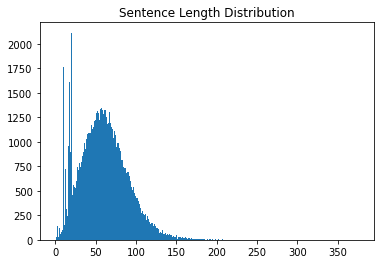

In [4]:
# 데이터 분포(문장길이 기준) 확인

min_len = 999 
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length  # 최단길이 검색
    if max_len < length: max_len = length  # 최장길이 검색
    sum_len += length # 모든 문장의 길이 sum

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw)) # 평균길이 출력

sentence_length = np.zeros((max_len), dtype=int) # 각 인덱스에 문장 길이 저장을 위한 zero array

for sen in raw:
    sentence_length[len(sen)-1] += 1 # 해당 문장의 길이에 맞는 nparray 인덱스에 저장 후 카운팅.

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

1) 길이 1 짜리 문장은 도대체 어떻게 생겨먹었지? : noise

2) 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가? : outlier, 중복제거

3) 어디서부터 어디까지 잘라서 쓰지? : mini batch를 위한 범위 설정

### 1) 길이가 1인 문장

In [5]:
# 1) 길이가 1인 문장 : 노이즈

def check_sentence_with_length(raw, length):
    '''
    길이별로 문장을 확인하는 함수. 
    raw : 문장 리스트
    length : 확인할 문장의 길이
    '''
    count = 0
    
    # raw(문장 리스트)에서 한 문장씩(sen) 가져와서 아래 수행
    for sen in raw:             
        if len(sen) == length:      # 전체 문장 하나씩 불러와서 맞는 길이 검색
            print(sen)              # 그 문장 출력
            count += 1              # 카운트.
            if count > 100: return  # 100개까지 출력

check_sentence_with_length(raw, 1)
check_sentence_with_length(raw, 2)

’
1.
2.
3.
4.
면접
음식
햇빛
과일
양파
Q:
4.
6.
..


### 2) outlier 확인 : 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가?


In [7]:
# 확인이 필요해 보이는 문장 모두 확인(outlier)

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [6]:
cnt = 0
for idx, _sum in enumerate(sentence_length):
    print(idx, _sum)
    cnt += 1
    if cnt == 20: break


0 1
1 13
2 25
3 137
4 24
5 121
6 50
7 57
8 77
9 103
10 1761
11 781
12 148
13 720
14 311
15 247
16 954
17 319
18 1611
19 898


In [8]:
sentence_length[10] # 1761 -> 길이가 11인 문장이 1761개
sentence_length[18] # 1611
sentence_length[20] # 2113

2113

In [9]:
# sentence_length[10]에 해당하는 데이터 확인
check_sentence_with_length(raw, 11) # -> 중복,,,

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

### 중복 제거후 다시 분포 확인

중복 제거는 Python의 기본 자료형 set을 활용할 겁니다. 

set은 집합을 정의하는 자료형인데, 중복을 허용하지 않아 변환 과정에서 자동으로 중복된 요소를 제거해 주거든요! 

대신 list의 순서가 뒤죽박죽될 수 있으니, 만약 번역 데이터처럼 쌍을 이뤄야 하는 경우라면 주의해서 사용하셔야 합니다!

중복을 제거한 후, 앞에서 분포를 확인한 소스를 다시 실행시켜 보겠습니다!

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


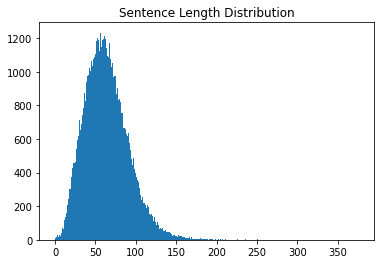

In [12]:
min_len = 999
max_len = 0
sum_len = 0

# 중복 제거
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

# 데이터 분포 확인
for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

-> 중복 제거로 
1. outlier 제거
2. 데이터 수 줄여줌

### 3) 어디서부터 어디까지 잘라서 쓰지?

마지막으로 '모든 데이터를 다 사용할 것이냐' 가 문제인데, 후에 

- **미니 배치를 만들 것**을 생각하면 
- **모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적**

입니다. 

- **미니 배치 특성상 각 데이터의 크기가 모두 동일**

해야 하기 때문에 

- **가장 긴 데이터를 기준으로 "Padding" 처리** (짧은 문장인경우 전체 길이는 맞춰두고 빈 공간을 padding)

를 해야 합니다. 위의 데이터에서 **만약 길이가 100인 문장까지만 사용한다면 데이터는 [ (77591 - 길이 100 초과 문장 수) x 100 ] 의 형태**를 갖겠지만 모두 사용할 경우 [ 77591 x 377 ] 로 전자보다 최소 **3.7배 큰 메모리를 차지**합니다. 학습 시간도 그만큼 더 오래 걸리고요.

길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 지양해야 합니다. 

- **여기서는 길이 150 이상의 데이터를 제거**

하고 사용하도록 할게요!

그리고 앞서 확인한 것처럼 

- **너무 짧은 데이터는 오히려 노이즈로 작용**할 수 있습니다. 
- **따라서 길이가 10 미만인 데이터도 제거**

하도록 하죠! 최종 데이터 분포도 함께 확인해봅시다.

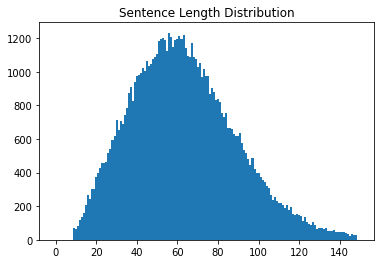

In [13]:
# batch 크기 결정, 분포 확인

max_len = 150 # 최대 문장 길이
min_len = 10  # 최소 문장 길이

# 길이 조건에 맞는 문장만 선택합니다. cleaned_corpus -> set으로 중복제거한 문장 list
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 2-3. 토큰화

1. 공백 기반
2. 형태소 기반

In [14]:
# 토크나이저 함수 작성: keras의 Tokenizer class

def tokenize(corpus):  
    '''corpus: Tokenized Sentence's List'''
    # keras의 Tokenizer class instance 생성 
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='') # 필터링 문자 없이 토크나이저에 모든 문자 사용
    
    # 문자 데이터를 입력받아서 리스트의 형태로 변환
    tokenizer.fit_on_texts(corpus)    # texts_to_sequences(or matrix) 전에 적용시켜야함
    
    # mapping: a list of texts (strings)를 받아 a list of sequences를 리턴
    tensor = tokenizer.texts_to_sequences(corpus) 
    
    # padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    '''args
    tensor : tokenizer를 거친 데이터 sequence
    padding='post' : 값 뒤에 패딩 (앞을 패딩하려면 'pre', default padding 값 = 0)
    
    return : Numpy array with shape (len(sequences), maxlen)
    '''
    
    return tensor, tokenizer

- `tf.keras.preprocessing.text.Tokenizer(filters='')`: (deprecated code ~ `tf.keras.layers.TextVectorization` 권장)
    - 링크: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
    - 설명: 
        - keras의 text tokenizer class. filter 매개변수는 제거할 문자집합. 
        - filter='' -> 제거 안함. 
        - defualt: ``` filter='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' ```

<br>

- `Tokenizer.fit_on_texts(corpus)`
    - 링크: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts
    - 설명: 
        - 문자열 리스트를 받아서, 
        - 단어를 빈도수 기준으로 단어집합을 생성
        - texts_to_sequences(or matrix) 전에 적용시켜야함

<br>

- `Tokenizer.texts_to_sequences(corpus)`
    - 링크: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences
    - 설명: 
        - 문자열 리스트를 받아 글자(character)와 숫자정보를 mapping (fit_on_texts에서 처리한 대로)
        - 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환.

<br>

- `tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')` (deprecated code)
    - 링크: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
    - 설명: 
        - Pads sequences to the same length.
        - 길이 매개변수가 주어지지 않았으면 최대 길이의 문장이 기준.
        - padding='post' : 값 뒤에 패딩 (앞을 패딩하려면 'pre(default)', default padding 값 = 0)
        - args : sequences <- tensor
        - return : Numpy array with shape (len(sequences), maxlen)


In [27]:
filtered_corpus[0]
filtered_corpus[1]
len(filtered_corpus) # 76908
print(filtered_corpus[:5]) # ~ 문장 하나씩 요소로 가지는 List
# -> tokenize()를 거치면 tensor(padded sequence)가 반환 -> embedding되어있지 않은...?

['최초 ‘일반인 탑승객’을 선정해 우주 프로그램을 촉진하는 것이 목표다.', '“AIG와 리먼 브라더스 두 기업 모두 납세자들에게는 수천억 달러의 구제 비용을 떠안긴 채, 경영진들은 수백만 달러의 보상금을 받고 유유히 회사를 떠났습니다.”', '소련 반체제 안드레이 사하로프상에서 사하로프상으로 명칭이 바뀐 이 상은 EU 총회가 매년 인권 분야에서 특별한 공헌을 했거나 민주주의와 법규정의 촉진을 위해 노력한 개인 혹은 단체에게 수여한다.', '당국자들은 조악한 폭탄이 담긴 옷가방 2개와 가솔린 병들이 파괴되지 않은 열차 칸에서 발견됐다고 말했다.', '반면 가장 무거운 ‘후이게리토’는 695kg이다.']


In [18]:
# input : filtered_corpus
# tokenizer() return : tensor(padded sequence), tokenizer(class instance)

type(tokenize(filtered_corpus)[0]) # tensor: numpy.ndarray
type(tokenize(filtered_corpus)[1]) # tokenizer: keras_preprocessing.text.Tokenizer

keras_preprocessing.text.Tokenizer

### (1) 공백 기반 토큰화

이전 스텝에서 얻은 정제된 데이터 `filtered_corpus`를 공백 기반으로 토큰화하여 
- 리스트 split_corpus에 저장한 후, 
- 위에서 작성한 tokenize() 함수를 사용해 
- 단어 사전과, 
- Tensor 데이터를 얻으세요! 그리고 
- 단어 사전의 크기를 확인하세요!


In [19]:
# 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())
    

In [28]:
print(split_corpus[:3])

[['최초', '‘일반인', '탑승객’을', '선정해', '우주', '프로그램을', '촉진하는', '것이', '목표다.'], ['“AIG와', '리먼', '브라더스', '두', '기업', '모두', '납세자들에게는', '수천억', '달러의', '구제', '비용을', '떠안긴', '채,', '경영진들은', '수백만', '달러의', '보상금을', '받고', '유유히', '회사를', '떠났습니다.”'], ['소련', '반체제', '안드레이', '사하로프상에서', '사하로프상으로', '명칭이', '바뀐', '이', '상은', 'EU', '총회가', '매년', '인권', '분야에서', '특별한', '공헌을', '했거나', '민주주의와', '법규정의', '촉진을', '위해', '노력한', '개인', '혹은', '단체에게', '수여한다.']]


In [29]:
# 공백 기반 토큰화를 진행한 후, 단어 사전의 길이를 확인

split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [30]:
# 생성된 단어사전 확인

for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


동사로 이루어진 단어를 살피면 **공백 기반 토큰화의 문제점**을 확인할 수 있습니다. <br>
1번 단어인 밝혔다. 는 밝히다 , 밝다 등과 유사한 의미를 지니고 있음에도 **전혀 다른 단어로 분류**되겠죠? <br>
이 때문에 공백 기반 토큰화는 **불필요하게 큰 단어 사전을 가지게 되며** 이는 연산량 증가로 이어집니다.

만일 `밝 + 혔다` 라고 토큰화했다면 어땠을까요? `밝 + 히다`, `밝 + 다` 같은 구절이 등장했을 때, 공통된 어절인 `밝` 은 하나로 묶여 학습 중에 의미를 파악하기가 수월해지겠죠? 동시에 단어 사전도 효율적으로 축소될 것입니다. 이를 위해 **형태소 분석기**가 존재합니다!

### (2) 형태소 기반 토큰화

한국어 형태소 분석기는 대표적으로 `Khaiii`와 `KoNLPy`가 사용됩니다. 이번 코스에서는 `KoNLPy`, 그중에서도 가장 성능이 준수한 `MeCab클래스`를 활용해 실습하도록 하겠습니다!

앞서 작성했던 코드를 활용해 
- MeCab 기반으로 생성된 단어 사전과 
- Tensor 데이터를 얻어 봅시다!


In [31]:
# MeCab 단어 사전

# 형태소 반환: mecab.morphs() ~ text에서 형태소를 반환
def mecab_split(sentence):
    return mecab.morphs(sentence)

# 형태소 vocab list 
mecab_corpus = []

# filtered_corpus -> mecab_corpus // 이전의 split_corpus는 단어로 tokenizing
for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [33]:
print(mecab_corpus[:3])
mecab_corpus[0]

[['최초', '‘', '일반', '인', '탑승객', '’', '을', '선정', '해', '우주', '프로그램', '을', '촉진', '하', '는', '것', '이', '목표', '다', '.'], ['“', 'AIG', '와', '리먼', '브라더스', '두', '기업', '모두', '납세자', '들', '에게', '는', '수천억', '달러', '의', '구제', '비용', '을', '떠안', '긴', '채', ',', '경영진', '들', '은', '수백만', '달러', '의', '보상금', '을', '받', '고', '유유히', '회사', '를', '떠났', '습니다', '.', '”'], ['소련', '반', '체제', '안드레이', '사하로프상', '에서', '사하로프상', '으로', '명칭', '이', '바뀐', '이', '상', '은', 'EU', '총회', '가', '매년', '인권', '분야', '에서', '특별', '한', '공헌', '을', '했', '거나', '민주주의', '와', '법', '규정', '의', '촉진', '을', '위해', '노력', '한', '개인', '혹은', '단체', '에게', '수여', '한다', '.']]


['최초',
 '‘',
 '일반',
 '인',
 '탑승객',
 '’',
 '을',
 '선정',
 '해',
 '우주',
 '프로그램',
 '을',
 '촉진',
 '하',
 '는',
 '것',
 '이',
 '목표',
 '다',
 '.']

In [35]:
# tokenizing, 단어장 크기 확인

mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


vocab size가 **237435 to 52279 !!** >> 사전 크기가 **4.5배** 감소

적어도 **한국어**를 처리할 때는 **공백 기반 토큰화**를 **"절대 지양"**하셔야 해요!



## 2-4. 공백 vs 형태소

자주 사용되는 `SentencePiece`같은 `Subword 기반 토큰화`보다 `형태소 분석기`가 좋은 성능을 내는 사례들이 종종 있는데요, 

`ETRI`에서 발표한 `한국어 BERT 모델인 KorBERT`가 대표적인 사례 중 하나입니다. 

아래 웹페이지를 방문하면 `모델의 자세한 구조`뿐 아니라 

`KorBERT 모델`을 `5가지 자연어 처리 태스크`를 기준으로 `평가`했던 흥미로운 결과까지 살펴보실 수 있습니다!

- [공공 인공지능 오픈 API·DATA 서비스 포털](https://aiopen.etri.re.kr/bertModel)

자연어 처리에서 `토크나이저`가 성능에 미치는 영향도가 크다는 것은 주지의 사실입니다만, 

위 링크에서 발표된 평가 결과를 살펴볼 때 `몇 가지 생각해 볼 만한 지점`이 있습니다.

아래 질문들에 대해 스스로 생각해 보고 본인의 생각을 정리해서 답변해 보시기 바랍니다. 사실 정답이 있는 문제는 아니기 때문입니다.


<br>

---
Q. 구글의 `Word Piece 기반 한국어 언어모델`이 `엑소브레인의 Word Piece 기반 한국어 언어모델`보다 전체적으로 성능이 크게 떨어지는 것은 어떤 의미일까요? 여기서 유의해야 할 것은 `언어모델(BERT)을 훈련시킨 원리는 동일`하며, `토크나이저가 구성된 원리도 Word Piece 기반으로 동일`하다는 점입니다.

A. `구글에서 배포한 BERT 모델`은 `한국어 전용 코퍼스를 바탕으로 훈련`된 것이 아니라 `Multilingual 코퍼스를 바탕으로 훈련`된 것이며, `Word Piece 모델 안에 포함된 subword` 안에도 `한국어가 아닌 여러 언어의 것이 섞여 있어서` `한국어 자연어처리 태스크`에 특화된 모델이 아닙니다. (상세한 내용은 https://github.com/google-research/bert 참조)

`엑소브레인`의 것은 `한국어 코퍼스에 특화된 형태`로 언어모델과 토크나이저가 훈련된 것이므로 엑소브레인과 구글의 BERT 모델의 한국어 테스크 성능 차이는 한국어에 특화된 언어 모델을 구축했을 때 기대할 수 있는 성능 향상치로 해석할 수 있습니다.

---

Q. 엑소브레인의 BERT에 `두 가지 버전`이 있는데, 이 중 `한국어 전용 형태소분석기 토크나이저를 사용한 버전`이 `WordPiece 모델 토크나이저를 사용한 버전`보다 대체로 성능이 좋다는 것의 시사점은 무엇일까요?

A. `WordPiece 모델`은 `해당 언어의 문법적 및 의미적 사전정보가 반영되지 않은` 채 `순수하게 통계적인 빈도 기반`으로 `자주 사용되는 반복 패턴`을 사전으로 등재해 놓은 것에 불과합니다. 

그에 비해 `정확한 한국어 문법과 의미정보를 바탕으로 개발된 형태소분석기`가 정확하게 동작한다면 

`현재까지 가장 성능이 좋다고 알려진 Subword 기반의 토크나이저보다 더 성능이 좋을 수 있음`을 보여 줍니다.

---

Q. `정교한 형태소분석기를 활용한 모델`의 성능이 더 좋을 수 있음에도 불구하고 `현장에서 SentencePiece 같은 Subword 기반 토크나이저`가 더욱 각광받는 이유는 무엇일까요?

A. 언어는 `지속적으로 변합`니다. `정교한 형태소분석기`의 성능을 유지하기 위해서는 `지속적인 데이터관리와 유지보수 작업`이 필요합니다.

그에 비해 `SentencePiece 모델`은 `코퍼스데이터로부터 쉽게 추출해서 생성 가능`하며, `Subword 기반`이기 때문에 `새롭게 생성되는 단어에 대한 OOV(Out-of-Vocabulary) 문제`에 대해서도 `robust하게 대처`할 수 있는 장점이 있습니다. 

그리고 `언어에 중립적`이기 때문에 `여러 언어가 섞여 나오는 텍스트`를 처리하는 데에도 능합니다.

무엇보다도, `특정 언어에 대한 부가지식이 없이`도 엔지니어가 `그 언어에 대한 작업을 손쉽게 진행`할 수 있도록 해준다는 점과 `그 언어에 특화된 토크나이저의 성능`에 뒤지지 않거나 대체로 능가하는 성능을 보여주기 때문입니다.

## 2-5. Decoding: Tensor to sentence

지금까지 문장을 `Tensor로 Encoding`하는 과정을 배웠는데요.
후에 모델이 생성한 `Tensor를 문장으로 Decoding`하는 과정도 필요하겠죠?

- tokenizer.sequences_to_texts() 함수를 사용하여 Decoding
- tokenizer.index_word 를 사용하여 Decoding

두 가지 방법으로 mecab_tensor[100] 을 원문으로 되돌려 보세요!
(여기서 띄어쓰기는 고려하지 않습니다!)

In [36]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

레바논 방송 매체 는 러시아 문화 센터 인근 서 폭발 이 발생 했 다고 전했 다 .


In [37]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue    # padding data 건너뛰기
    sentence += mecab_tokenizer.index_word[w] + " " # 띄어쓰기 추가

print(sentence)

레바논 방송 매체 는 러시아 문화 센터 인근 서 폭발 이 발생 했 다고 전했 다 . 


## 정리
---

1. 데이터 준비
    1. 데이터 다운로드, 라이브러리 import
    2. 데이터 확인
2. preprocessing
    1. noise 확인
    2. 중복 제거 -> outlier 제거
    3. 사용할 mini batch 문장 크기 설정(10~150) -> noise 제거
3. tokenizing
    1. 공백 기반: split, keras tokenizer
    2. 형태소 기반: mecab.morphs, keras tokenizer
    
    
data download ----`list`----> `raw`<br>

----`list(set(raw))`----> `cleaned_corpus`<br>

----minibatch----> `filtered_corpus`<br>

----공백기반:`.split()`----> `split_corpus` ----encoding----> `split_tensor`, `split_tokenizer`<br>

----형태소기반:`mecab.morphs()`----> `mecab_corpus` ----encoding----> `mecab_tensor`, `mecab_tokenizer`

<br>

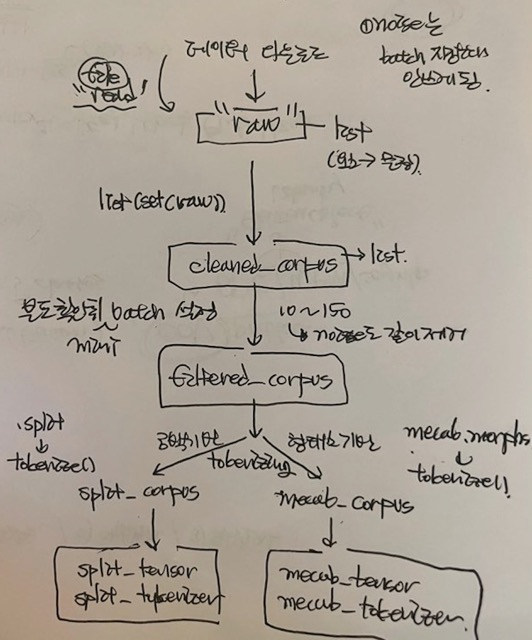